In [13]:
!pip install uszipcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
from geopy.distance import great_circle
from sklearn.linear_model import LinearRegression
import xgboost as xg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import altair as alt
import joblib
from joblib import dump, load
from nltk.corpus import stopwords
import uszipcode
from uszipcode import SearchEngine
import geopy
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
search = SearchEngine()


pd.set_option('display.max_columns', None)

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing 


In [17]:
####IMPORTANT --------------the above zipcode statistics only increased accuracy by 1 percent but increased the training
#time from less than a minute, to 13 minutes.

def prepare_listings_df(df,df2):
    ''' df is the first dataframe - the listings dataframe.
    df2 is the merged lat_long_df dataframe that gives the latitude/long coordinates of the city center.
    this takes only the necessary columns from the first dataframe, merges the two dataframes, then drops null values/columns'''
    
    df=df[['price','host_since','last_scraped','host_is_superhost','host_listings_count','host_identity_verified',
                               'latitude','longitude','property_type','room_type','accommodates','bathrooms_text',
                                 'bedrooms','beds','amenities','minimum_nights','maximum_nights',
                                'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                                'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                                'has_availability','availability_30','availability_60','availability_90',
                                'availability_365','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
                                'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                                'review_scores_checkin', 'review_scores_location',
                                'review_scores_value', 'instant_bookable','city','host_response_time','host_response_rate',
                                'host_acceptance_rate','calculated_host_listings_count',
                                'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                               'calculated_host_listings_count_shared_rooms']]
    
    df=pd.merge(df,df2,on='city')
    
    
    #drop null values in columns that will not be filled with median values
    null_columns=['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
    'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'beds','bedrooms','host_identity_verified','host_listings_count',
    'host_is_superhost','host_since','bathrooms_text','host_response_time','host_response_rate','host_acceptance_rate']

    #drop all null values that are not reviews
    df=df.dropna(axis=0, subset=null_columns)
    #df=df.drop(['id'],axis=1)
    return df

Note: the function "get distance" is adapted from the following source:

- RajRaj 1, et al. “Error While Getting the Distance between Two Co-Ordinates.” Stack Overflow, 1 Mar. 1965, https://stackoverflow.com/questions/50402199/error-while-getting-the-distance-between-two-co-ordinates. 

In [18]:
def filter_x(x,filter_lst):
    ''' if the value x is not in the filter list, replace it as other
    x: category string value
    filter_lst: list to filter x by
    returns--> x if in filter list, otherwise returs other'''
    if x in filter_lst:
        return x
    else:
        return 'other'
        
def top_amenities_score(x_lst):
    ''' Based off the top 10 amenities mentioned in the article linked below,
    how many of these amenities are listed in the airbnb listing. Used in the later
    function "amenities_len_lst_and_score"
    x_lst: the amenities list in the amenities column
    returns--> the number of amenities mentioned in top 10'''

    STOPWORDS= stopwords.words('english')
    top_amenities_lst=['pool','wifi','kitchen','parking','jacuzzi','tub','washer','laundry','air',
                         'check-in','pets','workspace']
    counter=0
    for item in x_lst:
        item=item.lower().split()
        for sub_item in item:
            if sub_item not in STOPWORDS:
                if sub_item in top_amenities_lst:
                    counter=counter+1
    return counter

        
def host_since_years(df):
    ''' change host since time to integer of days
    df=dataframe
    returns--> dataframe with host_since_years column changed to interger value
    '''
    new_df=df.copy(deep=True)
    new_df['host_since']=pd.to_datetime(new_df['host_since'])
    new_df['last_scraped']=pd.to_datetime(new_df['last_scraped'])
    new_df['days_being_host']=(new_df['last_scraped']-new_df['host_since']).astype(str)
    new_df['days_being_host']=new_df['days_being_host'].apply(lambda x:x.replace(' days',''))
    new_df=new_df[new_df['days_being_host']!='NaT']
    new_df['days_being_host']=new_df['days_being_host'].astype(int)
    new_df = new_df.drop(['host_since','last_scraped'], axis=1)
    return new_df


def true_false_to_binary(df,column_list):
    '''change true and false to binary 1 and 0
    df: dataframe
    column_list: list of columns to change to binary output
    returns--> dataframe with new binary column'''
    new_df=df.copy(deep=True)
    for column in column_list:
        new_df[column] = new_df[column].map({'t': 1, 'f': 0})
    return new_df


def reduce_categories(df):
    ''' reduce the property type category by only taking 
        the top 4 items, make everything else other
        df: dataframe
        returns--> dataframe with reduced category column for property type'''
    new_df=df.copy(deep=True)
    #find the count of each property type
    count_df=new_df[['property_type','accommodates']].groupby('property_type').count(
                ).reset_index().sort_values('accommodates',ascending=False).rename(columns={'accommodates':'count'})
    top_4_lst=list(count_df['property_type'])[:4] #find the top 4
    new_df['property_type']=new_df['property_type'].apply(lambda x: filter_x(x,top_4_lst))
    return new_df


def amenities_len_lst_and_score(df):
    '''this function completes 2 tasks:
    1) get the number of amenities in list
    2) get the ammenities score based on the top ammenities
    df: dataframe
    returns--> dataframe with length of amenities list, and amenity score'''
    new_df=df.copy(deep=True)
    new_df['amenities']=new_df['amenities'].apply(lambda x:x.replace('[','')
                        ).apply(lambda x:x.replace(']','')
                        ).apply(lambda x:x.replace('"','')
                        ).apply(lambda x:x.split(','))
    new_df['amenities_length']=new_df['amenities'].apply(lambda x:len(x))
    new_df['top_amenities_score']=new_df['amenities'].apply(lambda x:top_amenities_score(x))
    new_df=new_df.drop(['amenities'],axis=1)
    return new_df


def fill_null_median(df,column_lst):
    '''fill the null values with median value
    df: dataframe
    column_list: list of columns to fill null values with median
    returns--> dataframe with null values filled with median'''
    new_df=df.copy(deep=True)
    for column in column_lst:
        new_df[column] = new_df[column].fillna(new_df[column].median())
    return new_df
    

def get_distance(df):
    '''get the distance between lat and long coordinates from the city center
    df:dataframe
    returns--> dataframe with distance to city center, drops city center lat long coordinates'''
####  https://stackoverflow.com/questions/50402199/error-while-getting-the-distance-between-two-co-ordinates
    new_df=df.copy(deep=True)
    def distancer(row):
        '''smaller function defining distance'''
        airbnb_coord=(row['latitude'],row['longitude'])
        city_coord=(row['city_lat'],row['city_long'])
        return geopy.distance.geodesic(airbnb_coord, city_coord).miles
    new_df['distance_from_city']=new_df.apply(distancer,axis=1)
    new_df = new_df.drop(['city_lat','city_long'], axis=1)
    return new_df

def convert_dec_to_float(df,dec_columns):
    ''' convert any columns that are in string percent format to floats
    df: dataframe
    dec_columns=list of columns with string percentages
    returns--> datafrma with string percentage columns changed to float'''
    new_df=df.copy(deep=True)
    for column in dec_columns:
        new_df[column]=new_df[column].apply(lambda x:str(x).replace('%','')).astype(float)
    return new_df

def extract_number_from_string(df):
    '''extract number from the bathrooms text
    df:dataframe
    returns--> numbers from the bathrooms_text column'''
    new_df=df.copy(deep=True)
    new_df['bathrooms']=new_df['bathrooms_text'].str.extract('([0-9][.]*[0-9]*)').astype(float)
    new_df['bathrooms']=new_df['bathrooms'].fillna(1)
    new_df = new_df.drop(['bathrooms_text'],axis=1)
    return new_df

def ordinal_encode(df,column_lst):
    '''ordinal encode the category columns
    df:dataframe
    column_lst: list of columns that need to be ordinal encoded
    returns--> dataframe with new ordinal columns, no categories'''
    new_df=df.copy(deep=True)
    oe=OrdinalEncoder()
    for column in column_lst:
        new_df[column]=oe.fit_transform(new_df[[column]])
    return new_df

In [19]:
def clean_data_X(df):
    '''Combine functions from above to clean the data. IMPORTANT for it to be in the same order.
    df: dataframe
    returns--> dataframe with transformations made'''
    binary_column_lst=['host_is_superhost','host_identity_verified','has_availability','instant_bookable']
    null_column_lst=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_location','review_scores_value']
    one_hot_column_lst=['property_type','room_type','city','host_response_time']
    decimal_columns=['host_response_rate','host_acceptance_rate']
    
    new_df=df.copy(deep=True)
    new_df=host_since_years(new_df)
    new_df=true_false_to_binary(new_df,binary_column_lst)
    new_df=reduce_categories(new_df)
    new_df=amenities_len_lst_and_score(new_df)
    new_df=fill_null_median(new_df,null_column_lst)
    new_df=get_distance(new_df)
    new_df=convert_dec_to_float(new_df,decimal_columns)
    new_df=extract_number_from_string(new_df)
    #new_df=one_hot_encode(new_df,one_hot_column_lst)
    new_df=ordinal_encode(new_df,one_hot_column_lst)
    return new_df

In [20]:
def clean_data_Y(series):
    ''' change price value to integer
    series: target value
    returns--> $ string values changed to integers'''
    lst=list(series)
    new_lst=[]
    for item in lst:
        item=str(item).replace('$','')
        item=item.replace(',','')
        new_lst.append(float(item))
    #https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf#:~:text=Logarithmically%20transforming%20variables%20in%20a%20regression%20model%20is,effectiverelationship%20non-linear%2C%20while%20still%20preserving%20the%20linear%20model.
    return new_lst

In [21]:
def train_test_split_func(df):
    ''' train test split the dataframe
    df:dataframe
    returns--> X_train, X_test, y_train, y_test'''
    X = df.iloc[:, df.columns != 'price']
    y = df['price']

    # split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=0)

    X_train=clean_data_X(X_train)
    X_test=clean_data_X(X_test)
    y_train=np.log(clean_data_Y(y_train))
    y_test=np.log(clean_data_Y(y_test))
    return X_train, X_test, y_train, y_test

# Read in data for Austin

In [22]:
lat_long_df = pd.read_csv('/content/drive/MyDrive/Capstone/city_lat_long_coordinates.csv')
austin_listing_df=pd.read_csv('/content/drive/MyDrive/Capstone/austin_listings.csv.gz')
austin_listing_df['city']='Austin'
austin_listing_df=prepare_listings_df(austin_listing_df,lat_long_df)
X_train, X_test, y_train, y_test=train_test_split_func(austin_listing_df)
X_train=X_train.drop(['city'],axis=1)
X_test=X_test.drop(['city'],axis=1)
if 'Hotel room' in list(X_train.columns):
    X_train=X_train.drop(['Hotel room'],axis=1)

if 'Hotel room' in list(X_test.columns):
    X_test=X_test.drop(['Hotel room'],axis=1)
#just removed the hotel room category because there were only 5 in the dataset

### Feature Importance with Random Forest

In [23]:
rf_reg=RandomForestRegressor(n_estimators=140)
rf_reg.fit(X_train, y_train)
keys=list(X_train.columns)
values=list(rf_reg.feature_importances_)

features_df=pd.DataFrame(list(zip(keys, values)),columns =['keys', 'values'])

### Random Forest - keeping only top features and examining change in score outputs

In [24]:
def top_x_features(top_x_lst,X_train,X_test):
    mse_lst,mae_lst,r2_lst=[],[],[]
    for num in top_x_lst:
        X_train_copy=X_train.copy(deep=True)
        X_test_copy=X_test.copy(deep=True)
        top_values=list(features_df.sort_values(by = ['values'],ascending=False).head(num)['keys'])
        #only keep the top features in the model
        X_train_copy=X_train_copy[top_values]
        X_test_copy=X_test_copy[top_values]

        rf_reg=RandomForestRegressor(n_estimators=140)

        # Fitting the model
        rf_reg.fit(X_train_copy, y_train)

        # Predict the model
        y_pred = rf_reg.predict(X_test_copy)
        mse,mae,r2=mean_squared_error(y_test, y_pred),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)
        mse_lst.append(mse)
        mae_lst.append(mae)
        r2_lst.append(r2)
    return mse_lst,mae_lst,r2_lst

### FINAL MODEL: Random Forest Cross Validation with:
 - tuned parameter - n_estimators=140
 - only top 10 features used

In [25]:
austin_listing_df=pd.read_csv('/content/drive/MyDrive/Capstone/austin_listings.csv.gz')
austin_listing_df['city']='Austin'



In [26]:
austin_listing_df=prepare_listings_df(austin_listing_df,lat_long_df)

X_train, X_test, y_train, y_test=train_test_split_func(austin_listing_df)

X_train=X_train.drop(['city'],axis=1)
X_test=X_test.drop(['city'],axis=1)
if 'Hotel room' in list(X_train.columns):
    X_train=X_train.drop(['Hotel room'],axis=1)

if 'Hotel room' in list(X_test.columns):
    X_test=X_test.drop(['Hotel room'],axis=1)

In [27]:
rf_reg=RandomForestRegressor(n_estimators=140)
rf_reg.fit(X_train, y_train)
keys=list(X_train.columns)
values=list(rf_reg.feature_importances_)
features_df=pd.DataFrame(list(zip(keys, values)),columns =['keys', 'values'])
top_values=list(features_df.sort_values(by = ['values'],ascending=False).head(10)['keys'])

In [28]:
#Exporting training and testing data
#take only the top 10 features

X_train_copy=X_train[top_values]
print(X_train_copy.shape)
x_train_df = pd.DataFrame(X_train_copy)
#x_train_df.to_csv('x_train.csv')
X_test_copy=X_test[top_values]

x_test_df = pd.DataFrame(X_test_copy).reset_index()
#x_test_df.to_csv('x_test.csv')

y_test_df = pd.DataFrame(y_test)
#convert log_transformed price to get true price
y_test_df['price']= y_test_df[0].apply(lambda x: np.exp(x))
#y_test_df.to_csv('y_test.csv')
print(y_train.shape)
y_train_df = pd.DataFrame(y_train)
#convert log_transformed price to get true price
y_train_df['price']= y_train_df[0].apply(lambda x: np.exp(x))
#y_train_df.to_csv('y_train.csv')

(32181, 10)
(32181,)


In [29]:
#used the tuned parameter
rf_reg=RandomForestRegressor(n_estimators=140)
rf_reg.fit(X_train_copy, y_train)
y_pred= rf_reg.predict(X_test_copy)


#dump(rf_reg, 'rf_reg_model.joblib')

In [30]:
y_pred_df = pd.DataFrame(y_pred).reset_index()

#converting log-transformed price to get predcited price in dollars
y_pred_df['price']= y_pred_df[0].apply(lambda x: np.exp(x))


#y_pred_df.to_csv('y_pred.csv')
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred))

Mean squared error (MSE): 0.12
Coefficient of determination (R^2): 0.84


# Failure Analysis

In [31]:
#Reading in Excel file with combined X_test, y_test and y_pred data

failure_df = pd.read_csv('/content/drive/MyDrive/Capstone/Failure Analysis.csv')
failure_df =failure_df.rename(columns={'Test-price':'true_price', 'Pred price':'pred_price'})
failure_df.head()

,Unnamed: 0,index,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,log price-test,true_price,Pred log price,pred_price
0,0,19023,2,1.0,2,8.412171,100,-97.646130,1,2,30.36253,2294,4.077537,59.0,3.974413,53
1,1,43622,2,1.0,0,9.113018,100,-97.722069,1,3322,30.39860,2001,5.164786,175.0,5.069644,159
2,2,32357,7,1.0,0,3.445956,100,-97.779350,3,2,30.23656,3500,5.181784,178.0,6.076012,435
3,3,20288,6,2.0,0,0.917268,100,-97.747570,2,194,30.27162,1305,5.313206,203.0,5.698942,299
4,4,26148,2,1.0,0,1.267979,100,-97.744900,1,10,30.25124,3697,4.499810,90.0,5.169649,176


In [32]:
#Calculate price difference between predicted and true price
failure_df['price_diff'] =  round(((failure_df['true_price']-failure_df['pred_price'])*-1),0)
failure_df['price_diff'] =  failure_df['price_diff'].astype(int)
failure_df.head()

,Unnamed: 0,index,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,log price-test,true_price,Pred log price,pred_price,price_diff
0,0,19023,2,1.0,2,8.412171,100,-97.646130,1,2,30.36253,2294,4.077537,59.0,3.974413,53,-6
1,1,43622,2,1.0,0,9.113018,100,-97.722069,1,3322,30.39860,2001,5.164786,175.0,5.069644,159,-16
2,2,32357,7,1.0,0,3.445956,100,-97.779350,3,2,30.23656,3500,5.181784,178.0,6.076012,435,257
3,3,20288,6,2.0,0,0.917268,100,-97.747570,2,194,30.27162,1305,5.313206,203.0,5.698942,299,96
4,4,26148,2,1.0,0,1.267979,100,-97.744900,1,10,30.25124,3697,4.499810,90.0,5.169649,176,86


In [33]:
#See distribution of prices

# set counters for higher, lower and exact predictions
lower_counter = 0
higher_counter = 0
match_counter =0

total_count = len(failure_df['price_diff'])

for x in failure_df['price_diff']:
  if x == 0:
    match_counter+=1
  if x < 0:
    lower_counter+=1
  else:
    higher_counter+=1

print('Counts Lower: {}'.format(lower_counter))
print('Lower Percent: {}'.format(round((lower_counter/total_count*100),2)))
print('Counts Higher: {}'.format(higher_counter))
print('Higher Percent: {}'.format(round((higher_counter/total_count*100),2)))
print('Counts Match: {}'.format(match_counter))
print('Match Percent: {}'.format(round((match_counter/total_count*100),2)))

Counts Lower: 4868
Lower Percent: 45.38
Counts Higher: 5860
Higher Percent: 54.62
Counts Match: 263
Match Percent: 2.45


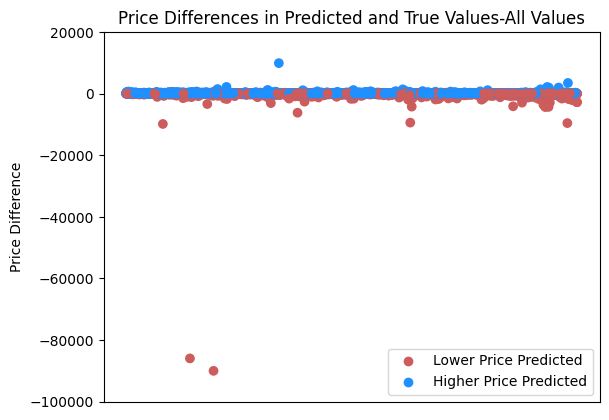

<Figure size 800x600 with 0 Axes>

In [34]:
#See price differences 

prices = list(failure_df['price_diff'].values)
colors = ['indianred' if val < 0 else 'dodgerblue' for val in prices]
#create scatterplot
plt.scatter(failure_df['index'],prices,c=colors)

unique_colors = list(set(colors))
labels = ['Lower Price Predicted','Higher Price Predicted']

# Create a list of legend handles for each color and label
legend_handles = [plt.scatter([], [], c=color, label=label) for color, label in zip(unique_colors, labels)]

# Add the legend 
plt.legend(handles=legend_handles)

#Remove xticks
plt.xticks([])

#Add label
plt.ylabel('Price Difference')

#Change y axis range
plt.ylim([-100000,20000])

#set title
plt.title('Price Differences in Predicted and True Values-All Values')
plt.figure(figsize=(8, 6))
plt.show()

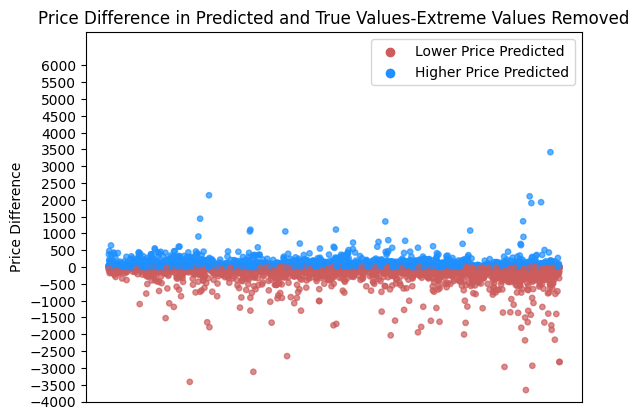

<Figure size 800x600 with 0 Axes>

In [35]:
#Remove top outlies to get a clearer picture
df = failure_df.copy(deep=True)
df = df[df['price_diff']<9000]

prices = list(df['price_diff'].values)
colors = ['indianred' if val < 0 else 'dodgerblue' for val in prices]

plt.scatter(df['index'],prices, c=colors, alpha=0.7,s=15)

unique_colors = list(set(colors))

labels = ['Lower Price Predicted','Higher Price Predicted']


# Create a list of legend handles for each color and label
legend_handles = [plt.scatter([], [], c=color, label=label) for color, label in zip(unique_colors, labels)]

# Add the legend
plt.legend(handles=legend_handles)

#Change y axis limits
plt.ylim([-4000, 7000])

#Remove x ticks
plt.xticks([])

# Set ticks of y axis
ticks = [-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500,0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]
plt.yticks(ticks)

#label y axis
plt.ylabel('Price Difference')



#set title
plt.title('Price Difference in Predicted and True Values-Extreme Values Removed')
plt.figure(figsize=(8, 6))
plt.show()


In [36]:
#Get percentages of values in certain price ranges

#getting distribution
counter_under51=0
counter_51to100=0
counter_101to200=0
counter_201to300=0
counter_301to400=0
counter_401to500=0
counter_greater500=0
counter_0=0

#taking the absolute value of the price
failure_df['price_diff_abs'] = failure_df['price_diff'].apply(lambda x:abs(x))

for x in failure_df['price_diff_abs']:
  if x == 0:
     counter_0+=1
  if x >0 and x<=50:
    counter_under51 +=1
  if x >=51 and x<=100:
    counter_51to100 +=1
  if x >=101 and x<=200:
    counter_101to200 +=1
  if x >=201 and x<=300:
    counter_201to300 +=1
  if x >=301 and x<=400:
    counter_301to400 +=1
  if x >=401 and x<=500:
    counter_401to500 +=1
  if x >=501:
    counter_greater500+=1

print('No Difference: {}'.format(counter_0))
print('Percent No Difference: {}'.format(round((counter_0/total_count*100),0)))
print('Difference less than or equal to $50: {}'.format(counter_under51))
print('Precent less than or equal to $50: {}'.format(round((counter_under51/total_count*100),0)))
print('Difference between $51 and $100: {}'.format(counter_51to100))
print('Percent between $51 and $100: {}'.format(round((counter_51to100/total_count*100),0)))
print('Difference between $101 and $200: {}'.format(counter_101to200))
print('Percent between $101 and $200: {}'.format(round((counter_101to200/total_count*100),0)))
print('Difference between $201 and $300: {}'.format(counter_201to300))
print('Percent between $201 and $300: {}'.format(round((counter_201to300/total_count*100),0)))
print('Difference between $301 and $400: {}'.format(counter_301to400))
print('Percent between $301 and $400: {}'.format(round((counter_301to400/total_count*100),0)))
print('Difference between $401 and $500: {}'.format(counter_401to500))
print('Percent between $401 and $500: {}'.format(round((counter_401to500/total_count*100),0)))
print('Difference greater than $501: {}'.format(counter_greater500))
print('Percent greater than $501: {}'.format(round((counter_greater500/total_count*100),0)))

No Difference: 263
Percent No Difference: 2.0
Difference less than or equal to $50: 6945
Precent less than or equal to $50: 65.0
Difference between $51 and $100: 1622
Percent between $51 and $100: 15.0
Difference between $101 and $200: 1063
Percent between $101 and $200: 10.0
Difference between $201 and $300: 338
Percent between $201 and $300: 3.0
Difference between $301 and $400: 188
Percent between $301 and $400: 2.0
Difference between $401 and $500: 92
Percent between $401 and $500: 1.0
Difference greater than $501: 217
Percent greater than $501: 2.0


# Specific Examples

In [37]:
#High price with high price difference

#columns to keep
cols_to_keep = ['accommodates', 'bathrooms', 'room_type','distance_from_city', 'host_response_rate', 'longitude', 'bedrooms',
       'host_listings_count', 'latitude', 'days_being_host','true_price','pred_price', 'price_diff']

first_example = failure_df[(failure_df['latitude']==30.26463) & (failure_df['longitude']==-97.73078) & (failure_df['index']==36633)]
first_example = first_example[cols_to_keep]

print(first_example)

     accommodates  bathrooms  room_type  distance_from_city  \
324            16       17.0          0            0.207165   

     host_response_rate  longitude  bedrooms  host_listings_count  latitude  \
324                 100  -97.73078        23                   13  30.26463   

     days_being_host  true_price  pred_price  price_diff  
324             3984      3666.0        4416         750  


In [38]:
#Calculate percent differnce for all testing data

#Calculate the percentage of true price for each difference
failure_df['price_perc'] =  abs(round((failure_df['price_diff']/failure_df['true_price']*100),0))

failure_df['price_perc'] =  failure_df['price_perc'].astype(int)

counter_5=0
counter_10=0
counter_20=0
counter_30=0
counter_40=0
counter_41=0

for i in failure_df['price_perc']:
  if i <=5:
    counter_5+=1
  if i >5 and i <=10:
    counter_10+=1
  if i <=20 and i >10:
    counter_20 +=1
  if i <=30 and i >20:
    counter_30 +=1
  if i <=40 and i >30:
    counter_40 +=1
  if i >40:
    counter_41+=1

print('Count <= 5% Difference: {}, Percent <= 5%: {}'.format(counter_5, round((counter_5/total_count*100),0)))
print('Count between 6-10% Difference:{}, Percent 6-10%: {}'.format(counter_10, round((counter_10/total_count*100),0)))
print('Count between 10 and 20% Difference:{},  Percent <=10-20%:{}'.format(counter_20, round((counter_20/total_count*100),0)))
print('Count between 20 and 30% Difference:{},  Percent <=20-30%:{}'.format(counter_30, round((counter_30/total_count*100),0)))
print('Count between 30 and 40% Difference:{},  Percent <=30-40%:{}'.format(counter_40, round((counter_40/total_count*100),0)))
print('Count >40% Difference:{},  Percent >40%:{}'.format(counter_41, round((counter_41/total_count*100),0)))

Count <= 5% Difference: 2516, Percent <= 5%: 23.0
Count between 6-10% Difference:1687, Percent 6-10%: 16.0
Count between 10 and 20% Difference:2273,  Percent <=10-20%:21.0
Count between 20 and 30% Difference:1407,  Percent <=20-30%:13.0
Count between 30 and 40% Difference:1000,  Percent <=30-40%:9.0
Count >40% Difference:1845,  Percent >40%:17.0


In [39]:
#Second and thrid examples
second_example = austin_listing_df[(austin_listing_df['latitude']==30.26118) & (austin_listing_df['longitude']== -97.77059)]
all_cols_to_keep= ['price', 'host_since', 'host_listings_count', 'latitude', 'longitude',
                   'property_type','accommodates','bathrooms_text', 'bedrooms','host_response_rate']
                   
second_example = second_example[all_cols_to_keep]
print(second_example)

           price  host_since  host_listings_count  latitude  longitude  \
5000   $9,999.00  2019-03-25                 14.0  30.26118  -97.77059   
18907     $97.00  2019-03-25                 10.0  30.26118  -97.77059   
37164    $118.00  2019-03-25                  3.0  30.26118  -97.77059   
54573     $84.00  2019-03-25                  3.0  30.26118  -97.77059   

                 property_type  accommodates bathrooms_text  bedrooms  \
5000               Entire home             8         1 bath       2.0   
18907              Entire home             8         1 bath       2.0   
37164              Entire home             8      1.5 baths       2.0   
54573  Entire residential home             8      1.5 baths       2.0   

      host_response_rate  
5000                 99%  
18907               100%  
37164                99%  
54573               100%  


In [40]:
#Second and third example testing data

second_example_test = failure_df[(failure_df['latitude']==30.26118) & (failure_df['longitude']== -97.77059)]
second_example_test = second_example_test[cols_to_keep]
second_example_test

,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,true_price,pred_price,price_diff
727,8,1.5,0,2.259765,99,-97.77059,2,3,30.26118,1172,118.0,111,-7
3512,8,1.0,0,2.259765,99,-97.77059,2,14,30.26118,1361,9999.0,111,-9888


In [41]:
#Example 4 data

example_four_test = failure_df[(failure_df['latitude']==30.24054) &(failure_df['longitude']== -97.72439)]
example_four_test = example_four_test[cols_to_keep]
example_four_test

,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,true_price,pred_price,price_diff
9931,4,1.0,0,1.877373,10,-97.72439,1,693,30.24054,2124,135.0,10000,9865


In [42]:
#Example 4 test data-all listings for that host
example_four_listings = failure_df[failure_df['host_listings_count']==693]
example_four_listings = example_four_listings[cols_to_keep]
example_four_listings.head()

,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,true_price,pred_price,price_diff
185,4,2.0,0,11.314605,10,-97.67878,2,693,30.42396,2124,9999.0,9999,0
214,2,1.0,0,2.079612,10,-97.72133,1,693,30.23833,2124,9999.0,9999,0
418,6,2.0,0,11.940845,10,-97.75985,3,693,30.43848,2124,9999.0,7350,-2649
684,6,1.0,0,1.909594,10,-97.72541,2,693,30.23981,2124,9999.0,9083,-916
918,4,1.0,0,3.390043,10,-97.70534,1,693,30.22387,2124,9999.0,9999,0


In [43]:
#Host response rate of 10% in training data
x_train1 = pd.DataFrame(X_train_copy).reset_index().reset_index()
x_train1 = x_train1.rename(columns={'level_0':'id'})

y_train1 = pd.DataFrame(y_train).reset_index()
y_train1 = y_train1.rename(columns={'index':'id', 0:'log_price'})
y_train1['price'] = y_train1['log_price'].apply(lambda x:np.exp(x))

all_train = pd.concat([x_train1,y_train1], axis=1)



host_response_df = all_train[all_train['host_response_rate']==10]
host_response_df.head()

,id,index,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,id,log_price,price
264,264,19320,4,1.0,0.0,9.430796,10.0,-97.71927,1.0,693.0,30.40303,2124,264,9.21024,9999.0
324,324,20872,4,1.0,0.0,1.149213,10.0,-97.71650,1.0,693.0,30.25861,2124,324,9.21024,9999.0
331,331,20312,4,1.0,0.0,1.814031,10.0,-97.72252,1.0,693.0,30.24206,2124,331,9.21024,9999.0
426,426,23527,6,1.0,0.0,1.781364,10.0,-97.72552,2.0,693.0,30.24171,2124,426,9.21024,9999.0
637,637,20684,6,2.0,0.0,9.721442,10.0,-97.71248,2.0,693.0,30.40663,2124,637,9.21024,9999.0


In [44]:
#Breaking down the values in training data with host response rate of 10%

host_response_breakdown = host_response_df.groupby(['price']).size()
host_response_breakdown

price
380.0        1
457.0        1
9999.0     115
10000.0      8
dtype: int64

In [45]:
#Example 
example_five_test = failure_df[(failure_df['latitude']==30.24041) &(failure_df['longitude']== -97.72418)]
example_five_test = example_five_test[cols_to_keep]
example_five_test

,accommodates,bathrooms,room_type,distance_from_city,host_response_rate,longitude,bedrooms,host_listings_count,latitude,days_being_host,true_price,pred_price,price_diff
1483,6,1.0,0,1.889557,100,-97.72418,2,679,30.24041,1940,267.0,291,24
4986,6,1.0,0,1.889557,10,-97.72418,2,693,30.24041,2124,10000.0,9430,-570
